In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

2025-07-08 18:12:39.108911: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-08 18:12:39.121246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751987559.135918   89842 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751987559.140177   89842 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751987559.151343   89842 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Defining url for datasets


In [3]:
train_ds_url = "Teeth DataSet/Teeth_Dataset/Training"
test_ds_url = "Teeth DataSet/Teeth_Dataset/Testing"
val_ds_url = "Teeth DataSet/Teeth_Dataset/Validation"

In [4]:
def load_images_from_folder(folder_path):
    dataset = keras.preprocessing.image_dataset_from_directory(
        folder_path,
        label_mode='categorical',
        image_size=(256, 256),
        batch_size=32,
        shuffle=True,
        seed=42
    
    )
    return dataset

In [5]:
train_ds = load_images_from_folder(train_ds_url)    
test_ds = load_images_from_folder(test_ds_url)
val_ds = load_images_from_folder(val_ds_url)

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


2025-07-08 18:12:45.074389: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-07-08 18:12:45.074419: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="-1"
2025-07-08 18:12:45.074425: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-07-08 18:12:45.074428: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-07-08 18:12:45.074431: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: noureldeen
2025-07-08 18:12:45.074433: I external/local_xla/xla/stream_executor/cuda/cu

In [6]:
class_names = train_ds.class_names
print("Class names:", class_names)

count = 0
for images, labels in train_ds:
    count += 1

train_size = count * 32
print("Training dataset size:", train_size)
count = 0
for images, labels in val_ds:
    count += 1
validation_size = count * 32
print("Validation dataset size:", validation_size)
    

Class names: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


2025-07-08 18:12:46.519007: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training dataset size: 3104
Validation dataset size: 1056


2025-07-08 18:12:47.304838: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


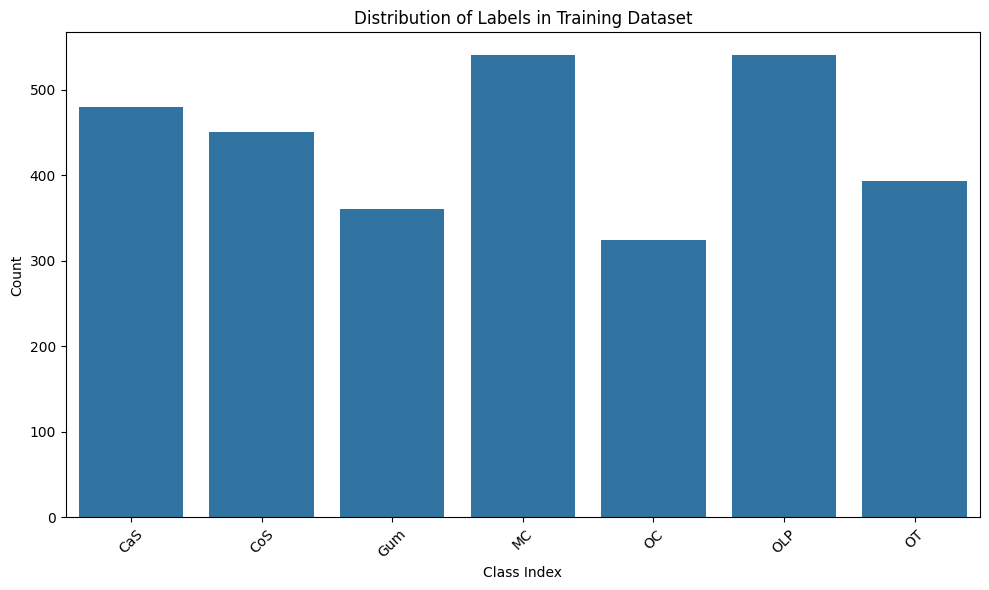

In [7]:
def get_all_labels(dataset):
    all_labels = []
    for _, labels in dataset:
        all_labels.extend(labels.numpy())
    return np.array(all_labels)

train_labels = get_all_labels(train_ds)

plt.figure(figsize=(10, 6))
sns.countplot(x=np.argmax(train_labels, axis=1))
plt.title('Distribution of Labels in Training Dataset')
plt.xlabel('Class Index')
plt.ylabel('Count')
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
plt.tight_layout()
plt.show()



Data is biased towards mc and olp and is minimum in oc and gum so we will add weights


In [8]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced',
                                        classes=np.arange(len(class_names)),
                                        y=np.argmax(train_labels, axis=1))
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.91875), 1: np.float64(0.98), 2: np.float64(1.225), 3: np.float64(0.8166666666666667), 4: np.float64(1.3611111111111112), 5: np.float64(0.8166666666666667), 6: np.float64(1.1221374045801527)}


2025-07-08 18:12:52.154928: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


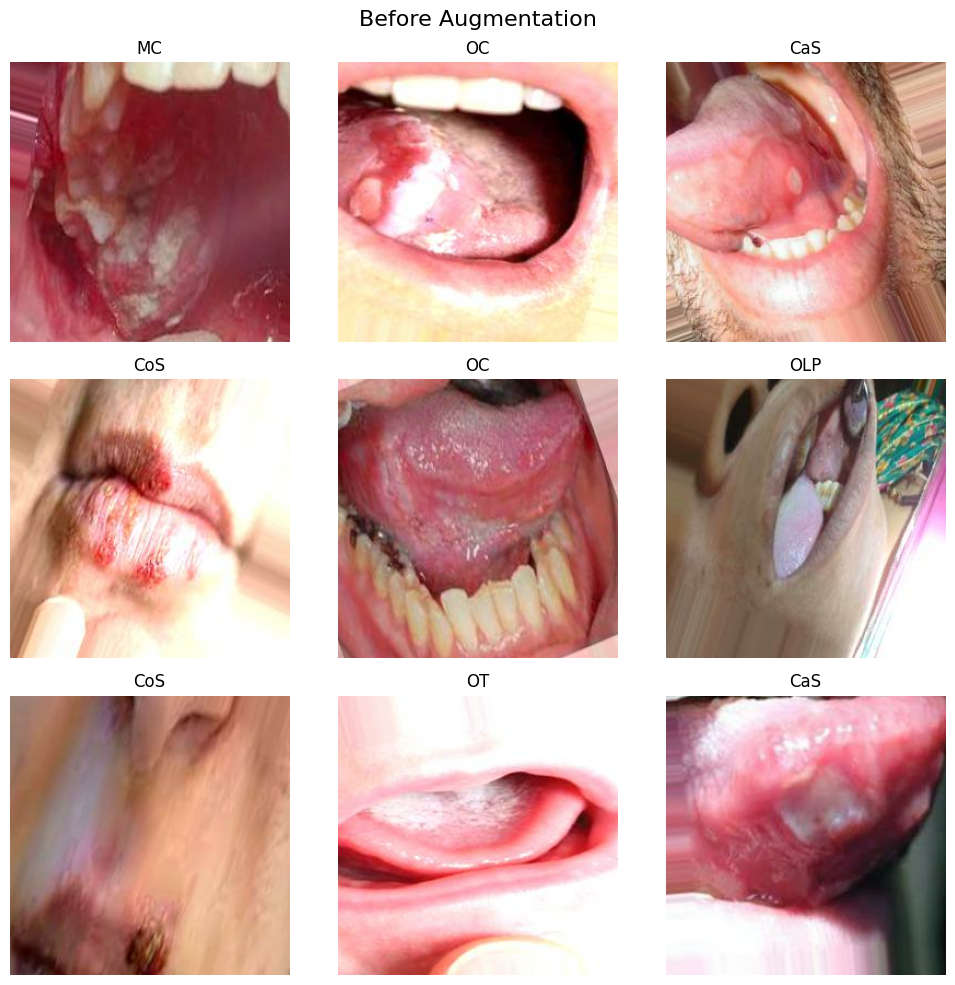

In [9]:
def show_batch(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label = tf.argmax(labels[i]).numpy() if labels.shape[-1] > 1 else labels[i].numpy()
            plt.title(class_names[label])
            plt.axis("off")
    plt.suptitle("Before Augmentation", fontsize=16)
    plt.tight_layout()
    plt.show()

show_batch(train_ds, class_names)


In [10]:
normalization_layer = keras.layers.Rescaling(1./255)
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
])


train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x), training=True), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


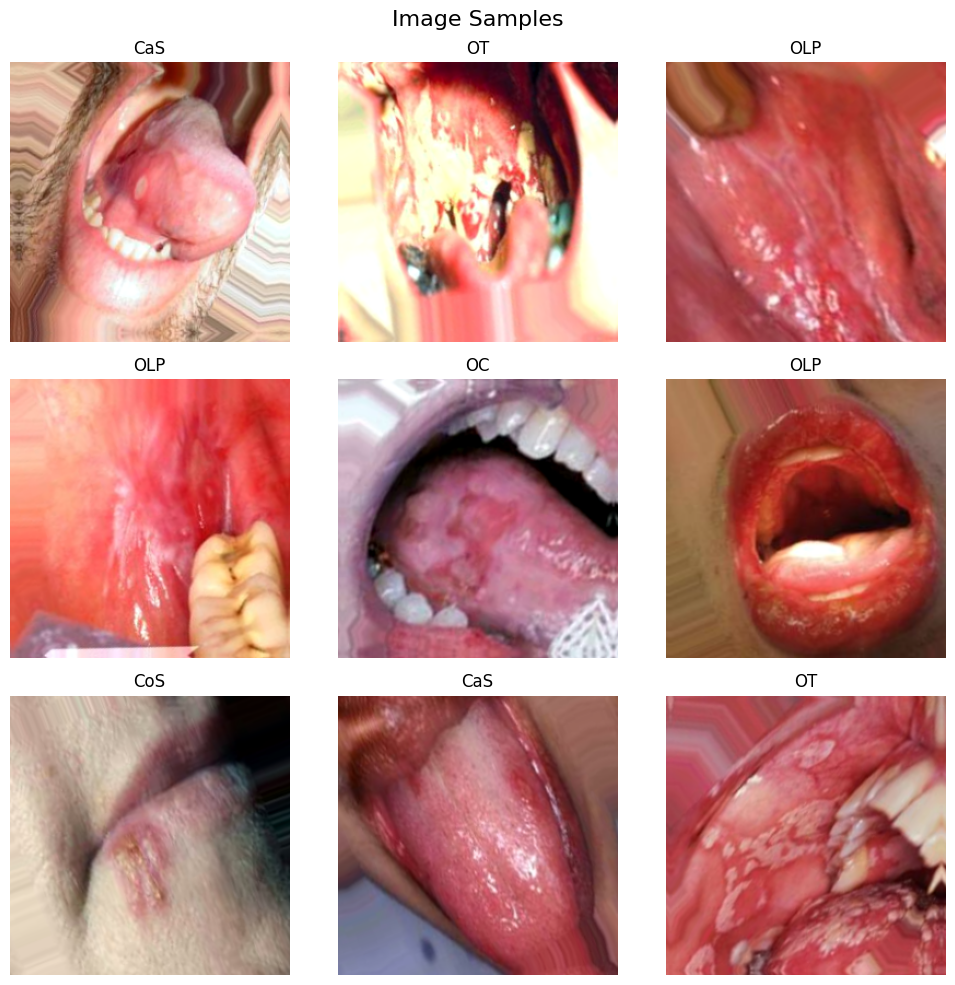

In [11]:
def show_batch(dataset, class_names, is_normalized=True):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            img = images[i].numpy()
            if is_normalized:
                img = np.clip(img * 255, 0, 255).astype("uint8")
            else:
                img = img.astype("uint8")
            plt.imshow(img)
            label = tf.argmax(labels[i]).numpy() if labels.shape[-1] > 1 else labels[i].numpy()
            plt.title(class_names[label])
            plt.axis("off")
    plt.suptitle("Image Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

show_batch(train_ds, class_names, is_normalized=True)


In [12]:
input_shape = (256, 256, 3)
model = keras.models.Sequential([

    keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=input_shape), 
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.GlobalAveragePooling2D(),
 
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])
model.summary()
    

/home/noureldeen/Data/Computer vision internship /First session /Teeth classification/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,455 (493.96 KB)

 Trainable params: 125,959 (492.03 KB)

 Non-trainable params: 496 (1.94 KB)

In [13]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',     
    factor=0.5,              
    patience=2,              
    min_lr=1e-7,             
    verbose=1                
)
train_steps = int(train_size / 32) 
validation_steps = int(validation_size / 32)
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=30,
          class_weight=class_weights,
          steps_per_epoch=train_steps,
          validation_steps=validation_steps,
          callbacks=[
              keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
              reduce_lr
          ])

Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 70s 680ms/step - Precision: 0.5331 - Recall: 0.0361 - accuracy: 0.2388 - loss: 1.8406 - val_Precision: 0.1449 - val_Recall: 0.1449 - val_accuracy: 0.1449 - val_loss: 3.3733 - learning_rate: 0.0010
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 65s 664ms/step - Precision: 0.6551 - Recall: 0.1143 - accuracy: 0.3550 - loss: 1.6017 - val_Precision: 0.1449 - val_Recall: 0.1449 - val_accuracy: 0.1449 - val_loss: 5.4282 - learning_rate: 0.0010
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 670ms/step - Precision: 0.6813 - Recall: 0.1625 - accuracy: 0.4029 - loss: 1.4939 - val_Precision: 0.2262 - val_Recall: 0.1644 - val_accuracy: 0.1984 - val_loss: 3.1231 - learning_rate: 0.0010
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 68s 693ms/step - Precision: 0.6705 - Recall: 0.2143 - accuracy: 0.4575 - loss: 1.3914 - val_Precision: 0.2970 - val_Recall: 0.1936 - val_accuracy: 0.2335 - val_loss: 2.7615 - learning_rate: 0.0010
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 68s 691ms/step - Preci

Text(0, 0.5, 'Accuracy')

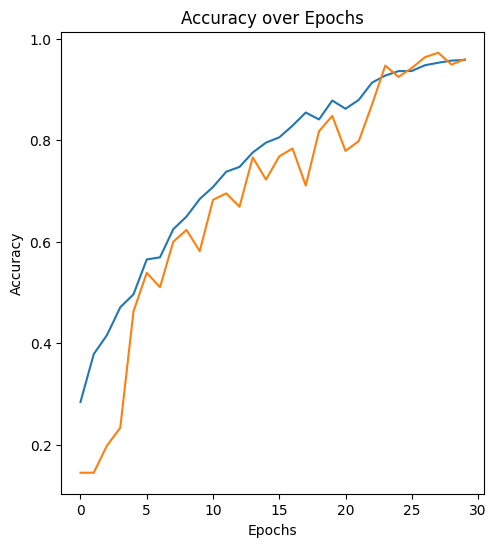

In [14]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


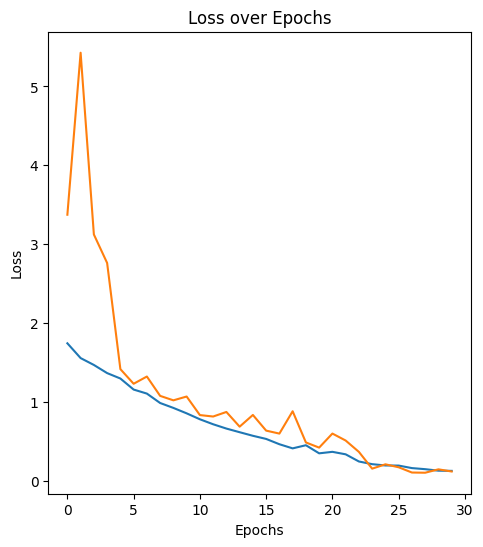

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [16]:
model.save("teeth_classification_model.h5")

In [17]:
loaded_model = keras.models.load_model("teeth_classification_model.h5")

In [18]:
loss, acc, precision, recall = model.evaluate(train_ds)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")


97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 405ms/step - Precision: 0.9840 - Recall: 0.9736 - accuracy: 0.9768 - loss: 0.0702
Test Accuracy: 0.9786
Test Precision: 0.9846
Test Recall: 0.9757


In [19]:
loss, acc, precision, recall = loaded_model.evaluate(test_ds)
print(f"Test Accuracy: {acc * 100:.4f}%")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9724 - loss: 0.1015 - precision_1: 0.9761 - recall_1: 0.9706
Test Accuracy: 96.8872%
Test Precision: 0.9726
Test Recall: 0.9660


In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # assuming categorical

y_pred = np.array(y_pred)
y_true = np.array(y_true)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

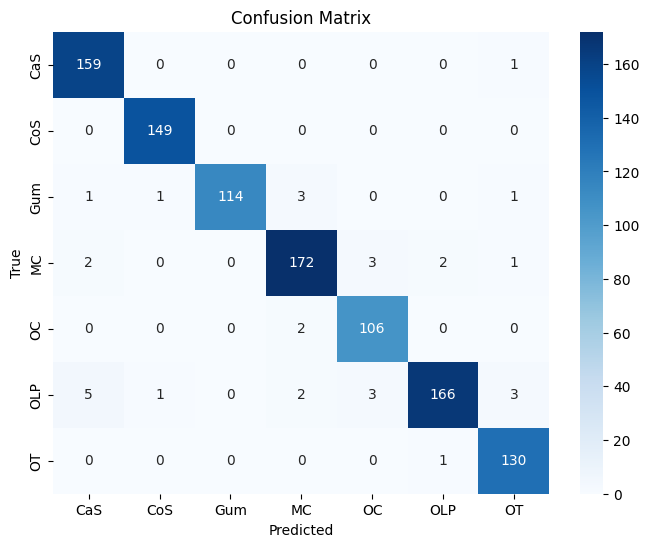

In [21]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


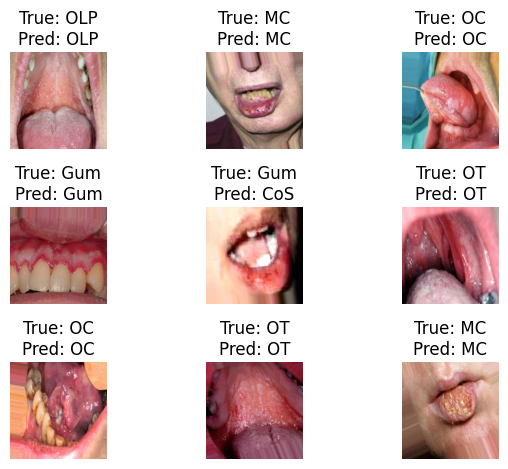

2025-07-08 20:35:52.675743: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
# view some predictions

for images, labels in test_ds.take(1):
    preds = model.predict(images)
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy() * 255 ).astype("uint8"))
        true_label = class_names[np.argmax(labels[i].numpy())]
        pred_label = class_names[np.argmax(preds[i])]
        plt.title(f'True: {true_label}\nPred: {pred_label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()